In [1]:
import numpy as np
import pandas as pd
from collections import Counter


# Audio feature extraction
import librosa as lb

# Visualization
import matplotlib.pyplot as plt
import librosa.display 
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot


# Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from mlxtend.plotting import plot_decision_regions
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier  #GBM algorithm
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance


# Render figures interactively in the notebook
%matplotlib inline

# Audio widget for playback
from IPython.display import Audio

# Importing files
from os import listdir
from os.path import isfile, join

### Preprocessing in python and postgreSQL

In [ ]:
# # Before my postgreSQL manipulation, one of my tables has some preprocessing needed.
# df_features = pd.read_csv('features_data.csv')

# # Preprocessing for clean merging in SQL
# df_features['filename'] = df_features['filename'].str[:15]
# df_features = df_features.drop(columns='Unnamed: 0')
# df_features['actor'] = df_features['filename'].str[:4]
# df_features.to_csv('features_data.csv', sep=',', encoding='utf-8')

# In postgreSQL, I created a database with several tablesd from the CREMA-D dataset and joined them together. 
# A .txt file of command line actions can be found in the repo. I am reading that final table back into pandas here.
# df_final = pd.read_csv('final.csv')

In [5]:
# data processed in external postgress database

# read processed total dataset
df_2 = pd.read_csv('features_data_v2.csv')
# read processed data ONLY anger vs neutral
# df_AN = pd.read_csv('anger_neutral_df.csv')
# # read processed data ONLY anger/disgust vs neutral/happy
# df_ADHN = pd.read_csv('anger_neutral_happy_disgust.csv')

In [7]:
df_2.emotion_label.value_counts()

F    1268
H    1267
A    1266
D    1264
S    1263
N    1082
Name: emotion_label, dtype: int64

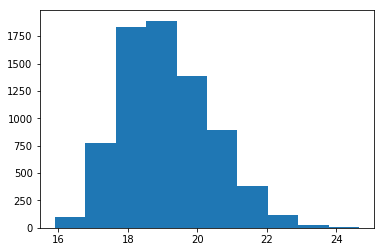

In [8]:
# observing distribution of certain variables, after outliers were removed
plt.hist(df_2['contrast']);

In [ ]:
# creating pairplots to observe feature interactions with the target

def plot_features(df, sample_size=500):
    '''Pairplot creator to assess feature strength. '''
    
    
    sample = (df.drop(['Unnamed: 0', 'filename', 'actor', 'emotion_label', 'affect',
        'Age', 'Sex', 'Race', 'Ethnicity',
       'Female', 'Male', 'African American', 'Asian', 'Caucasian', 'Unknown'], axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='affect_binary', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_2)  

### Splitting train and test data

In [12]:
# creating X and y for model. This model only predicts on Anger or Neutral.

X, y = df_2.drop(['Unnamed: 0','filename', 'actor', 'emotion_label', 'affect','affect_binary'], axis=1), df_2['emotion_label']

# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# applying scalar
std = MinMaxScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)


In [100]:
# creating X and y for model. This model predicts on anger/disgust or neutral/happy

X_1, y_1 = df_ADHN.drop(['Unnamed: 0','Unnamed: 0.1','filename', 'actor', 'emotion_label', 'affect',
        'Sex', 'Race', 'Ethnicity',
       'sex_binary', 'affect_binary', 'chroma', 'flatness', 'contrast_std','Age', 'Female', 'Male', 'African American', 'Asian',
       'Caucasian', 'Unknown', 'mfcc'], axis=1), df_ADHN['affect_binary']

#X, y = np.array(X), np.array(y)

# hold out 20% of the data for final testing
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=.2, random_state=10)

# applying standard scalar
std = MinMaxScaler()
std.fit(X_train_1.values)
X_tr_1 = std.transform(X_train_1.values)
X_te_1 = std.transform(X_test_1.values)

In [49]:
# Selecting different classifiers for modeling.

# logistic regression
lr = LogisticRegression()
# K Nearest Neihbors
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
# Random Forest
forest = RandomForestClassifier(n_estimators=100)
# Xgradientboost
xgb1 = XGBClassifier()


In [50]:
# setting parameter values to loop through for each model in Gridsearch CV.

params_lr = [{
    'penalty': ['l1', 'l2'], 
    'C': np.logspace(0,4,10)
}]

params_knn = {
    'n_neighbors': [3, 5, 10, 20]
}

params_xgb = [{
    'max_depth':range(2,6,2),
    #'scale_pos_weight':[1,2],
    'min_child_weight':range(1,6,2)
}]

kf = KFold(n_splits=5, shuffle = True, random_state = 1001)


In [43]:
# grid search CV to optimize parameter selection with logistic regression and KNN.

# clf_log = GridSearchCV(estimator=lr, param_grid=params_lr, cv=kf)
#lr.fit(X_tr, y_train)
# clf_knn = GridSearchCV(estimator=knn, param_grid=params_knn)
# knn.fit(X_tr, y_train)
xgb2 = xgb1.fit(X_tr, y_train)

In [51]:
# only anger/disgust and neutral/happy with XGradient Boost
clf_xgb = GridSearchCV(estimator=xgb1, param_grid=params_xgb, cv=kf)
clf_xgb.fit(X_tr, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1001, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': range(2, 6, 2), 'min_child_weight': range(1, 6, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
# only anger and neutral class with XGradient Boost

clf_xgb_AN = GridSearchCV(estimator=xgb1, param_grid=params_xgb, cv=skf.split(X_tr,y_train))
clf_xgb_AN.fit(X_tr, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x108121678>,
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': range(3, 10, 2), 'scale_pos_weight': [1, 2, 3, 4, 5], 'min_child_weight': range(1, 6, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
clf_xgb_ADHN.best_params_

{'max_depth': 5, 'min_child_weight': 1, 'scale_pos_weight': 1}

In [35]:
clf_xgb_AN.best_params_

{'max_depth': 3, 'min_child_weight': 3, 'scale_pos_weight': 1}

### Making models

In [29]:
def make_confusion_matrix(model, threshold, X, y):
    '''This function creates a confusion matrix showing the predictions of a class if the propbabilty of
    being in that class is greater than the threshold'''
    
#     y_hat = (model.predict_proba(X)[:,0] > threshold)
#     confusion = confusion_matrix(y, y_hat)
    confusion = confusion_matrix(y, model.predict(X))
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
           #xticklabels=['negative', 'positive'],
           #yticklabels=['negative', 'positive']);
    #plt.xlabel('prediction')
    #plt.ylabel('actual')

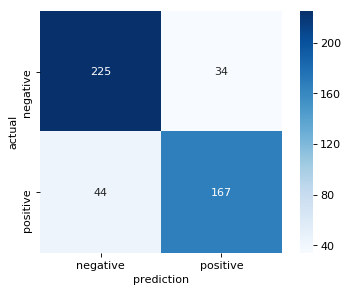

In [48]:
# anger/disgust vs happy/neutral

make_confusion_matrix(clf_xgb_ADHN, .5, X_te, y_test)

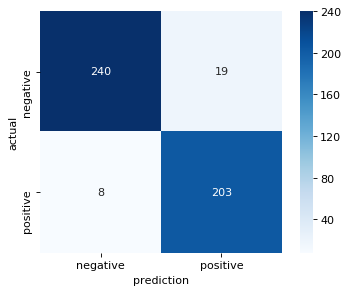

In [39]:
# only anger and neutral

make_confusion_matrix(clf_xgb_AN, .5, X_te, y_test)

In [31]:
def roc_plots(model):
    probs = model.predict_proba(X_te)
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)
    print(f'AUC {auc}')
    print(f'f1 {f1_score(y_test, model.predict(X_te))}')
    print(f'recall {recall_score(y_test, model.predict(X_te))}')
    print(f'precision {precision_score(y_test, model.predict(X_te))}')
    print(f'accuracy {accuracy_score(y_test, model.predict(X_te))}')
    
    fpr, tpr, thresholds = roc_curve(y_test
                                     , probs)
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


In [37]:
precision_score(y_test, lr.predict(X_te), average=None)

array([0.57419355, 0.26122449, 0.28947368, 0.37777778, 0.31654676,
       0.40979955])

AUC 0.9729912715694706
f1 0.9376443418013857
recall 0.9620853080568721
precision 0.9144144144144144
accuracy 0.9425531914893617


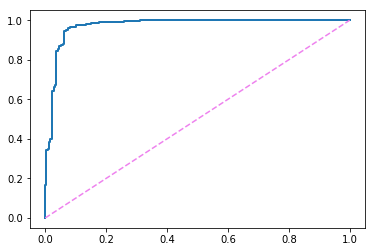

In [44]:
# only anger and neutral

roc_plots(clf_xgb_AN)

AUC 0.91875423155044
f1 0.8106796116504854
recall 0.7914691943127962
precision 0.8308457711442786
accuracy 0.8340425531914893


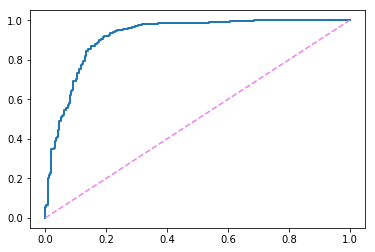

In [50]:
# only anger/disgust and neutral/happy

roc_plots(clf_xgb_ADHN)

### Feature selection


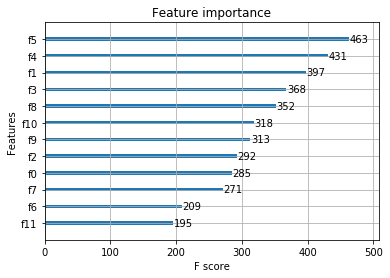

In [53]:
# Below is a function of xgboost classifier with illustrates relative importance of a feature within a model. 
# This was used to trim unneeded features.

model = XGBClassifier()
model.fit(X_tr, y_train)

plot_importance(model)
pyplot.show()

In [55]:
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

model = XGBClassifier()
model.fit(X_tr, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_te)
predictions = [value for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [value for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 43.39%
Thresh=0.050, n=12, Accuracy: 43.45%
Thresh=0.054, n=11, Accuracy: 43.12%
Thresh=0.070, n=10, Accuracy: 42.65%
Thresh=0.073, n=9, Accuracy: 42.91%
Thresh=0.075, n=8, Accuracy: 42.58%
Thresh=0.080, n=7, Accuracy: 42.38%
Thresh=0.082, n=6, Accuracy: 41.70%
Thresh=0.090, n=5, Accuracy: 40.62%
Thresh=0.095, n=4, Accuracy: 39.95%
Thresh=0.102, n=3, Accuracy: 39.88%
Thresh=0.111, n=2, Accuracy: 39.14%
Thresh=0.119, n=1, Accuracy: 39.20%


With feature selection from XGBoost, I removed features: 6, 0 , 12, 3, 13, 17, 15 (chroma, flatness, contrast_std, all dem) 

In [195]:
# save the model to disk
import pickle
name = 'finalized_model.sav'
pickle.dump(model, open(name, 'wb'))

### Testing

In [196]:
def extract_features(filename):
    '''Loading in audiofiles and extracting features. Features include:
        - mfcc = Mel-frequency cepstral coefficients. Commonly used for vocals.
        - centroid = Spectral Centroid. Represents mean value of frequency form. 
        - flatness = Spectral flatness. Distinguishes noisy vs harmonic sound.
        - tempo = Spectral onset envelope. Describes rythm.
        - cens = Chroma Energy Normalized Statistics. Smooths frequency windows for matching.
        - energy = Root Mean Square Energy. Computes energy of each frame.
        - melspec = Mel-Scaled Spectrogram.
        - contrast = Spectral Contrast.
        - tonnetz = Tonnetz. Computes tonal centroid features.
        - chroma = Chromagram from waveform.
    '''
    
    # load in file. y is the waveform, sr is the sampling rate.
    y, sr = lb.load(filename)
    
    # Short-time Fourier transformation.
    stft = np.abs(lb.stft(y))
    S, phase = lb.magphase(np.abs(stft))

    # all features chroma, contrast, energy, flatness, and MFCC
    mfcc = np.mean(lb.feature.mfcc(y=y, sr=sr))   
    mfcc_std = np.std(lb.feature.mfcc(y=y, sr=sr))
    centroid = np.mean(lb.feature.spectral_centroid(y=y, sr=sr))
    centroid_std = np.std(lb.feature.spectral_centroid(y=y, sr=sr))
    flatness = np.mean(lb.feature.spectral_flatness(y=y, S=S))
    flatness_std = np.std(lb.feature.spectral_flatness(y=y, S=S))
    tempo = np.mean(lb.feature.tempogram(y=y, sr=sr))
    tempo_std = np.std(lb.feature.tempogram(y=y, sr=sr))
    cens = np.mean(lb.feature.chroma_cens(y=y, sr=sr))
    cens_std = np.std(lb.feature.chroma_cens(y=y, sr=sr))
    energy = np.mean(lb.feature.rmse(y=y))
    energy_std = np.std(lb.feature.rmse(y=y))
    melspec = np.mean(lb.feature.melspectrogram(y=y, sr=sr))
    melspec_std = np.std(lb.feature.melspectrogram(y=y, sr=sr))
    contrast = np.mean(lb.feature.spectral_contrast(y=y, sr=sr))
    contrast_std = np.std(lb.feature.spectral_contrast(y=y, sr=sr))
    tonnetz = np.mean(lb.feature.tonnetz(y=y, sr=sr))
    tonnetz_std = np.std(lb.feature.tonnetz(y=y, sr=sr))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr))
    chroma_std = np.std(librosa.feature.chroma_stft(S=stft, sr=sr))
    zero = np.mean(librosa.feature.zero_crossing_rate(y=y))
    zero_std = np.std(librosa.feature.zero_crossing_rate(y=y))

    # Create a dict of features
    audio_features = {'filename': filename,
                     'mfcc': mfcc,
                     'mfcc_std': mfcc_std,
                     'centroid': centroid,
                     'centroid_std': centroid_std,
                     'flatness': flatness,
                     'flatness_std': flatness_std,
                     'tempo': tempo,
                     'tempo_std':tempo_std,
                     'cens': cens,
                     'cens_std':cens_std,
                     'energy': energy,
                     'energy_std': energy_std,
                     'melspec': melspec,
                     'melspec_std':melspec_std,
                     'contrast': contrast,
                     'contrast_std': contrast_std,
                     'tonnetz': tonnetz,
                     'tonnetz_std':tonnetz_std,
                     'chroma': chroma,
                     'chroma_std': chroma_std,
                     'zero': zero,
                     'zero_std': zero_std

                     }
    return audio_features


In [203]:
def test_function(filename):
    varname = extract_features(filename)
    varname = pd.DataFrame(varname, index=[0])
    varname = varname.drop(columns=['cens', 'cens_std', 'centroid', 'centroid_std',
                                    'chroma','contrast_std', 'filename', 'flatness', 'melspec', 'melspec_std',
                                    'mfcc', 'tempo', 'tempo_std', 'tonnetz', 'tonnetz_std'])
    #varname = std.transform(varname.values)
    #varname = varname.values
    std_test = MinMaxScaler()
    std_test.fit(varname.values)
    varname = std_test.transform(varname.values)
    return clf_xgb_ADHN.predict(varname)

In [204]:
test_function('angry_test.mp3')

array([0])